# Music genre prediction

Сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Иморты

In [1]:
import os
import re
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostClassifier, Pool, cv

import scipy
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [57]:
try:
    df_train = pd.read_csv('/home/aart/datasets/workshop/kaggle_music_genre_train.csv')
    df_test = pd.read_csv('/home/aart/datasets/workshop/kaggle_music_genre_test.csv')
except: 
    url_train = "https://raw.githubusercontent.com/MarkvsLoopvs/yandex_workshop1/main/kaggle_music_genre_train.csv"
    url_test = "https://raw.githubusercontent.com/MarkvsLoopvs/yandex_workshop1/main/kaggle_music_genre_test.csv"
    df_train = pd.read_csv(url_train)
    df_test = pd.read_csv(url_test)

In [3]:
RANDOM_STATE = 42

## EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


В обоих датафреймах есть пропуски в столбцах `key`, `mode` и `tempo`. Посмотрим на них позже.

In [6]:
display(df_train.head(1),df_test.head(1))

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.48,0.67,182653.0,0.351,0.0176,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.45,Country


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301,0.757,146213.0,0.679,0.0,A#,0.303,-7.136,Minor,0.356,90.361,4-Apr,0.895


In [7]:
df_train['music_genre'].value_counts()

Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

Классы несбаласированы, но экстремально низких и высоких значений нет.

В тренировочном датасете имеем 14 признаков:
* Категориальные - `instance_id`, `track_name`, `key`, `mode`, `obtained_date`
* Количественные - `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `liveness`, `loudness`, `speechiness`, `tempo`, `valence`
И таргет `music_genre`. Теперь рассмотрим каждый признак по отдельности.

### instance_id

Это просто индекс. Отбросим его из основного датафрейма, сохраним в отдельные серии для иных целей (подготовка файла-сабмита, etc.)

In [8]:
train_id = df_train['instance_id']
test_id = df_test['instance_id']

df_train = df_train.drop(columns=['instance_id'])
df_test = df_test.drop(columns=['instance_id'])

### duration_ms

In [9]:
df_train.groupby('music_genre')['duration_ms'].describe()

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,2601.0,208896.554018,90558.777943,-1.0,185455.00,219733.0,254840.00,638427.0
Anime,1901.0,210078.527617,100497.835524,-1.0,153093.00,231427.0,272880.00,1086493.0
Blues,2858.0,229354.083975,128719.172300,-1.0,173554.25,220789.0,278480.25,2019293.0
Classical,1373.0,284025.983977,221342.550856,-1.0,152120.00,243173.0,368147.00,1778440.0
Country,2120.0,195467.119811,77584.417571,-1.0,179503.50,207305.0,234130.00,477573.0
Electronic,2564.0,244518.579173,173967.319531,-1.0,192491.75,236800.0,297006.50,4497994.0
Hip-Hop,1145.0,194388.653275,85910.779960,-1.0,162038.00,206240.0,246793.00,485729.0
Jazz,1239.0,243244.999193,137910.313816,-1.0,171817.00,235467.0,306636.50,1352413.0
Rap,2428.0,195752.223641,86454.947788,-1.0,167119.50,207573.5,243929.25,579293.0


In [10]:
df_test['duration_ms'].describe()

count    5.099000e+03
mean     2.173974e+05
std      1.156374e+05
min     -1.000000e+00
25%      1.737335e+05
50%      2.175000e+05
75%      2.642470e+05
max      1.360027e+06
Name: duration_ms, dtype: float64

В обоих датафреймах есть значения `-1`. Очевидно это пропуски.

In [11]:
miss_duration_train = df_train[df_train['duration_ms'] == -1].shape[0]
miss_duration_test = df_test[df_test['duration_ms'] == -1].shape[0]

shape_train = df_train.shape[0]
shape_test = df_test.shape[0]

print(f"Пропусков длительности в трейне {miss_duration_train}, что соответствует \
{(miss_duration_train/shape_train)*100:2.4}% oт всех данных")
print(f"Пропусков длительности в тесте {miss_duration_test}, что соответствует \
{(miss_duration_test/shape_test)*100:2.4}% oт всех данных")

Пропусков длительности в трейне 2009, что соответствует 9.851% oт всех данных
Пропусков длительности в тесте 509, что соответствует 9.982% oт всех данных


10% это значительно. Мы не хотим терять эти данные, так что заполним пропуски медианой.

In [12]:
mask_duration_train = df_train['duration_ms'] != -1
mask_duration_test = df_test['duration_ms'] != -1

median_duration_train = df_train.loc[mask_duration_train, 'duration_ms'].median()
median_duration_test = df_test.loc[mask_duration_test, 'duration_ms'].median()

df_train.loc[~mask_duration_train, 'duration_ms'] = median_duration_train
df_test.loc[~mask_duration_test, 'duration_ms'] = median_duration_test

### instrumentalness

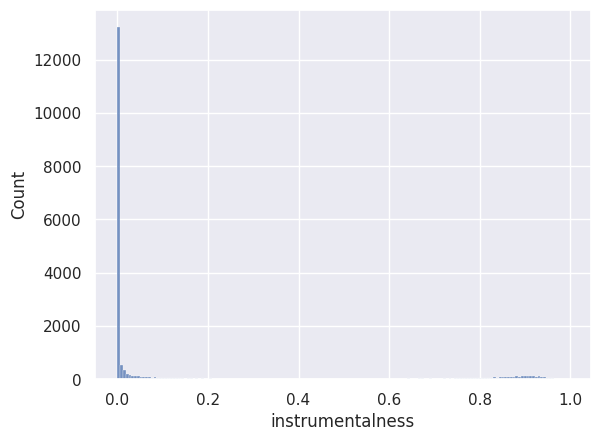

In [13]:
sns.histplot(x='instrumentalness',data=df_train);

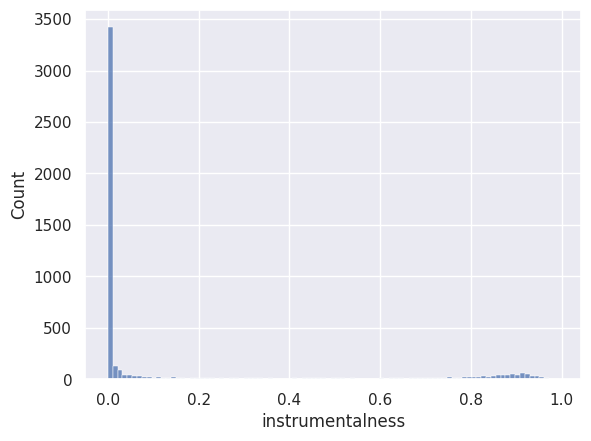

In [14]:
sns.histplot(x='instrumentalness',data=df_test);

In [15]:
null_instrumentalness_train = df_train[df_train['instrumentalness'] == 0].shape[0]
null_instrumentalness_test = df_test[df_test['instrumentalness'] == 0].shape[0]

print(f"Нулевых значений инструментальности в трейне{null_instrumentalness_train}, \
что соответствует {(null_instrumentalness_train/shape_train)*100:2.4}% от всех данных")
print(f"Нулевых значений инструментальности в тесте {null_instrumentalness_test}, \
что соответствует {(null_instrumentalness_test/shape_test)*100:2.4}% от всех данных")

Нулевых значений инструментальности в трейне5978, что соответствует 29.31% от всех данных
Нулевых значений инструментальности в тесте 1510, что соответствует 29.61% от всех данных


Скорее всего 0.0 - пропущенные значения. Так или иначе, фича с третью пропущенных данных бесполезна.

In [16]:
df_train = df_train.drop(columns=['instrumentalness'])
df_test = df_test.drop(columns=['instrumentalness'])

### key и mode

In [17]:
df_train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

In [18]:
df_test['key'].unique()

array(['A#', 'G#', 'A', 'B', 'D', 'F#', 'F', 'G', 'C', nan, 'D#', 'C#',
       'E'], dtype=object)

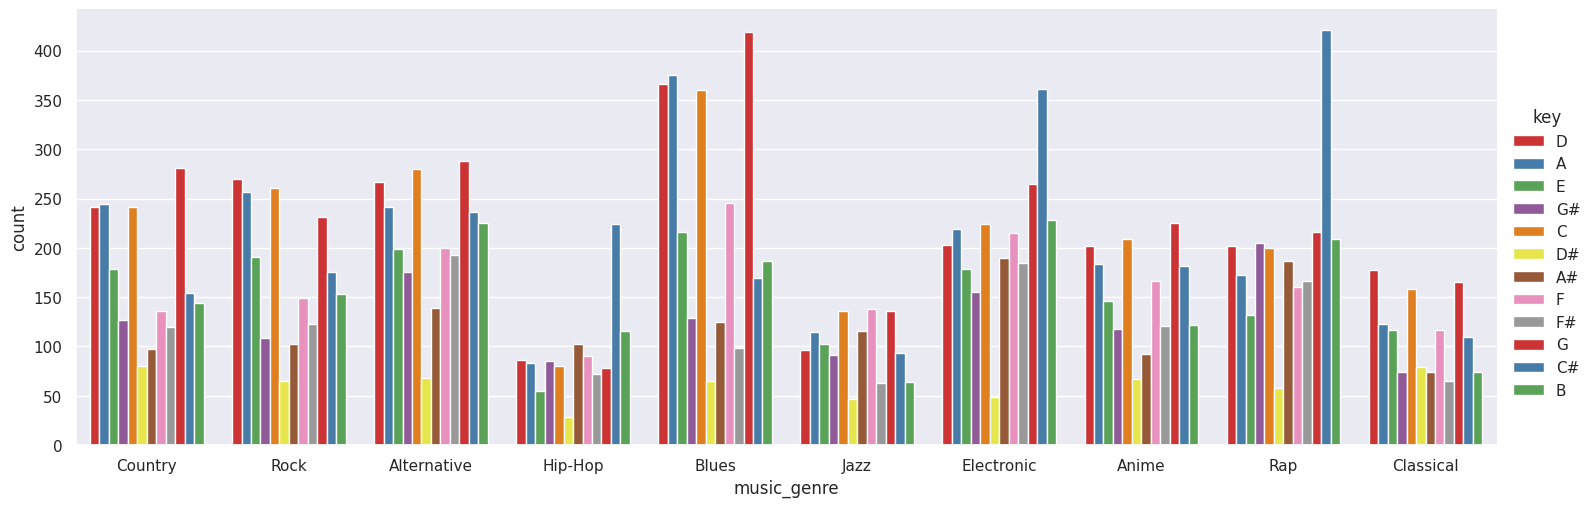

In [19]:
sns.catplot(x="music_genre", hue="key",data=df_train, kind="count",height=5, aspect=3.0, palette = 'Set1');

С ключами все в порядке, они подлежат one hot endcoding'у.

In [20]:
df_train['mode'].unique()

array(['Major', 'Minor', nan], dtype=object)

In [21]:
df_test['mode'].unique()

array(['Minor', 'Major', nan], dtype=object)

Такая же ситуация с ладами.

In [22]:
cat_features = ['key','mode']
ohe_encoder = OneHotEncoder(drop='first', sparse=False)

In [23]:
train_temp = ohe_encoder.fit_transform(df_train[cat_features]) #обучение и применение к train
df_train[ohe_encoder.get_feature_names()] = train_temp 
df_train.drop(cat_features, axis=1, inplace=True) 

test_temp = ohe_encoder.transform(df_test[cat_features]) #применение к test
df_test[ohe_encoder.get_feature_names()] = test_temp 
df_test.drop(cat_features, axis=1, inplace=True) 

### track_name

Эту фичу мы будем удалять, но перед этим синжинирим из нее парочку других фич. Первое что мне кажется релевантным - названия треков жанра anime.

In [24]:
df_train.loc[df_train['music_genre'] == 'Anime'].sample(5)

,track_name,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,obtained_date,...,x0_D,x0_D#,x0_E,x0_F,x0_F#,x0_G,x0_G#,x0_nan,x1_Minor,x1_nan
10811,Kocchi Wo Muiteyo,0.0518,0.548,313213.0,0.7170,0.1890,-4.671,0.0270,98.006,4-Apr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3918,plot,0.9600,0.228,68590.0,0.0304,0.1040,-34.677,0.0373,73.684,4-Apr,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3780,All might with U.A. Students,0.0755,0.396,149320.0,0.7190,0.0831,-8.351,0.0411,150.003,3-Apr,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11834,Their Waters Were Mingled Together,0.9470,0.109,613608.0,0.3300,0.1500,-15.522,0.0440,63.422,4-Apr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6679,Telecaster Stripes,0.0045,0.563,233198.0,0.9420,0.3200,-3.289,0.0476,142.019,4-Apr,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Высоки шансы, что при запуске такой строчки кода хотя бы один из треков будет содержать в своем названии хирогану, катакану, ханьцзы или хангыль. Напишем функцию и создадим фичу, которая будет нести информацию, содержит ли трек в своем названии символ CJK (Chinese, Japanese, Korean).

In [25]:
def cjk_detect(texts):
    # korean
    if re.search("[\uac00-\ud7a3]", texts):
        return 1
    # japanese
    if re.search("[\u3040-\u30ff]", texts):
        return 1
    # chinese
    if re.search("[\u4e00-\u9FFF]", texts):
        return 1
    return 0

In [26]:
df_train['cjk'] = df_train['track_name']
df_test['cjk'] = df_test['track_name']

df_train['cjk'] = df_train['cjk'].apply(cjk_detect)
df_test['cjk'] = df_test['cjk'].apply(cjk_detect)

Вторую фичу которую можно извлечь - длина названия. 

In [27]:
df_train['length_track_name'] = df_train['track_name'].str.len()

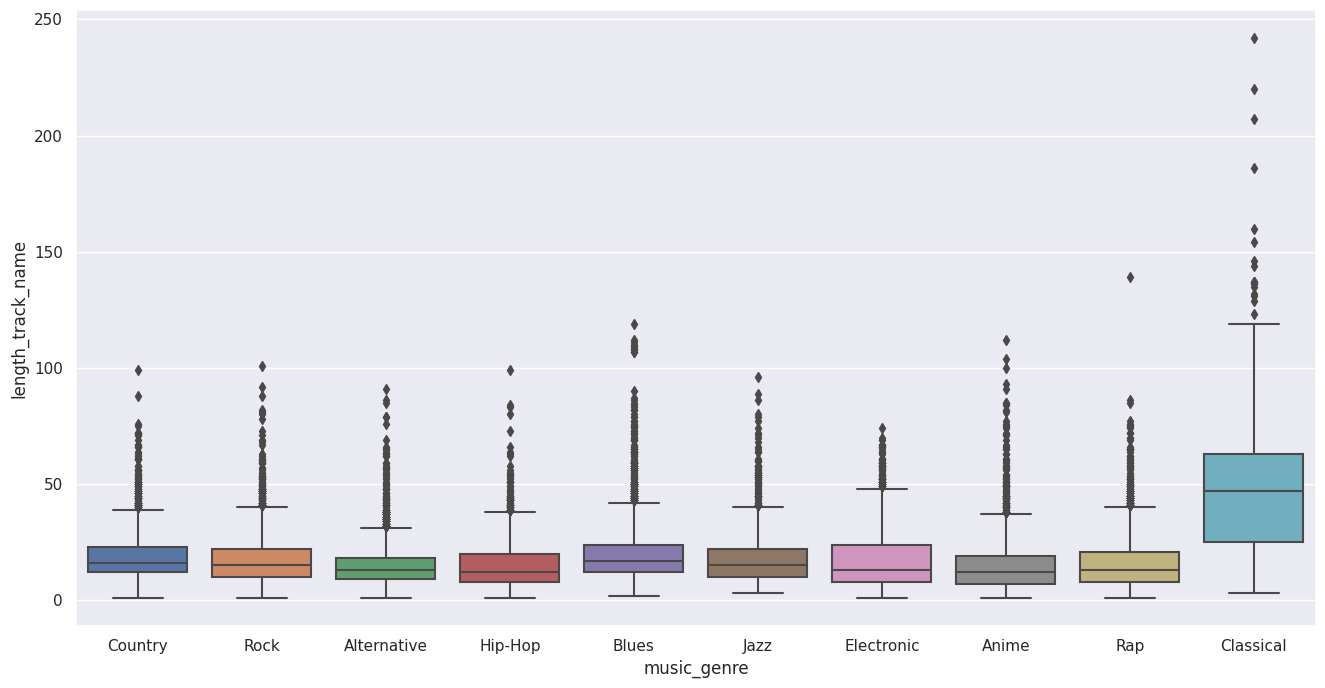

In [28]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='length_track_name')
plt.show()

Видим что у классической музыки средняя длина названия трека гораздо выше чем у остальных жанров. Полезно для классификации.

In [29]:
df_test['length_track_name'] = df_test['track_name'].str.len()

In [30]:
df_train = df_train.drop(columns = ['track_name'])
df_test = df_test.drop(columns = ['track_name'])

### obtained_date

In [31]:
df_train['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

In [32]:
df_test['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

Просто дата добавления в датабазу. Бесполезная фича.

In [33]:
df_train = df_train.drop(columns=['obtained_date'])
df_test = df_test.drop(columns=['obtained_date'])

### tempo

In [34]:
print(df_train['tempo'].isna().sum(), df_test['tempo'].isna().sum())

442 121


Пропусков в `tempo` совсем немного, терять данные не будем, заменим медианой.

In [35]:
median_tempo_train = df_train['tempo'].median()
median_tempo_test = df_test['tempo'].median()

df_train['tempo'] = df_train['tempo'].fillna(median_tempo_train)
df_test['tempo'] = df_test['tempo'].fillna(median_tempo_test)

### Остальные признаки

#### acousticness

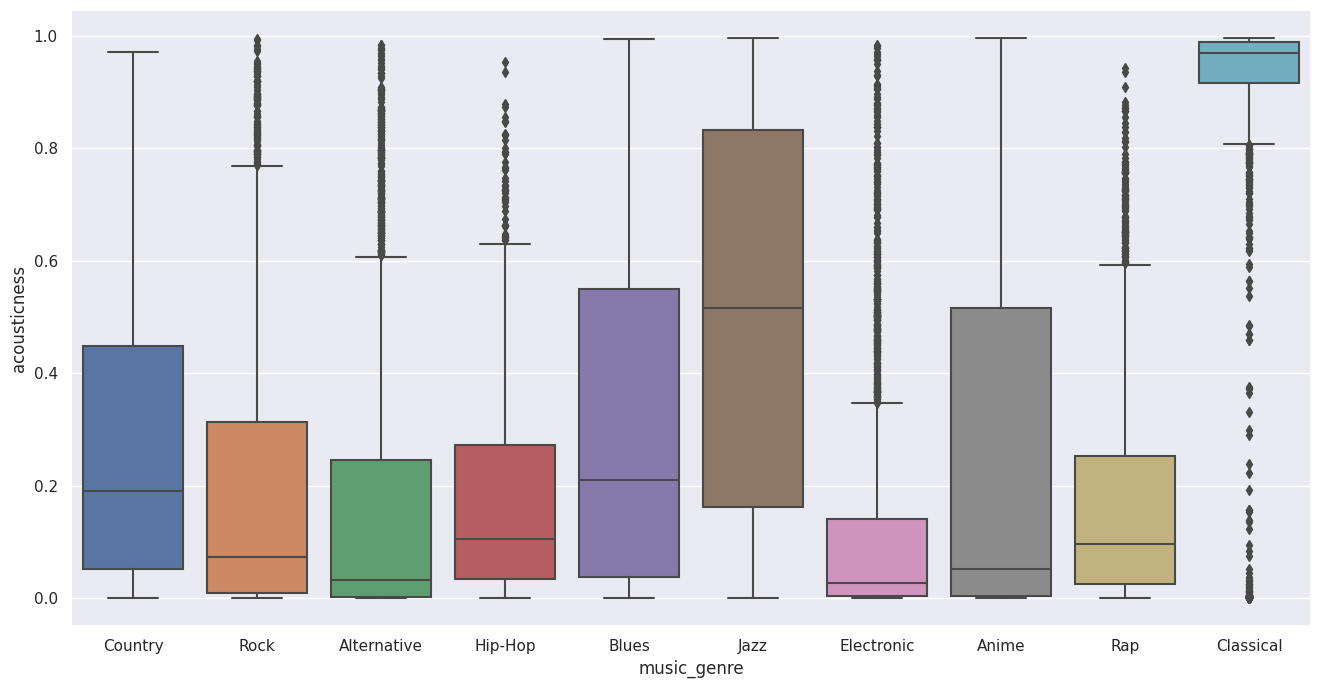

In [36]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='acousticness')
plt.show()

#### danceability

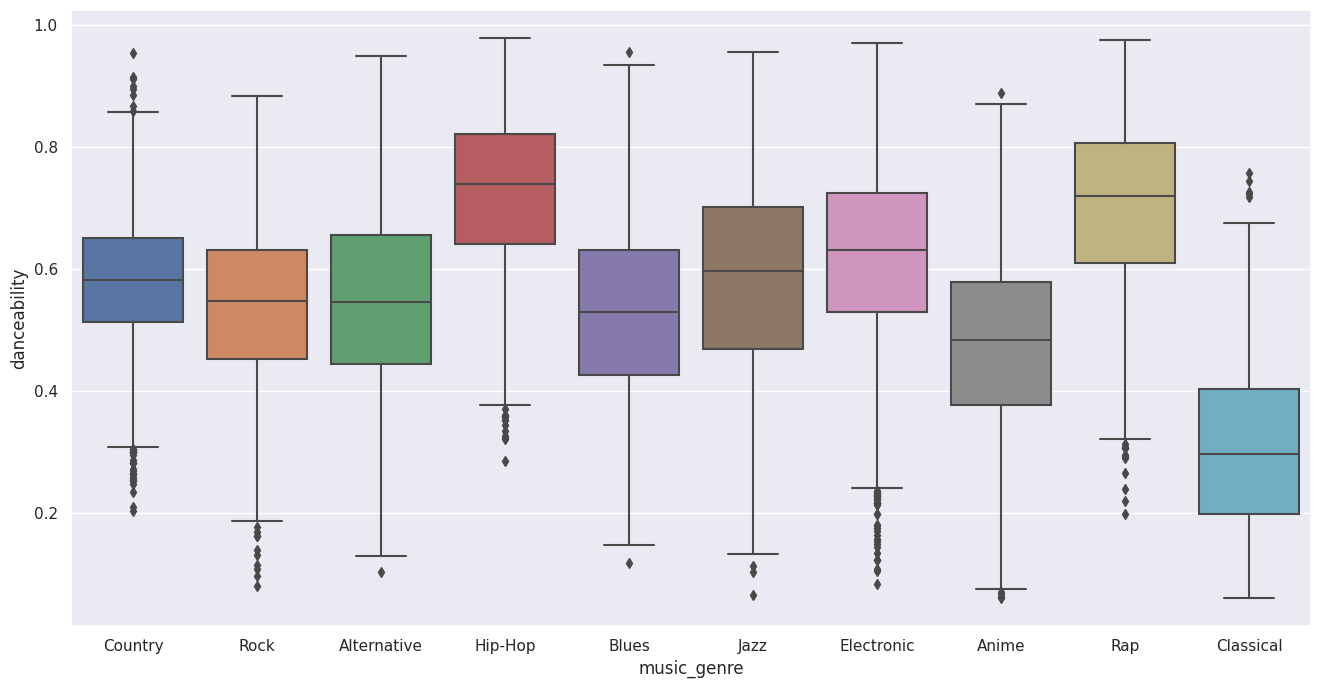

In [37]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='danceability')
plt.show()

#### energy

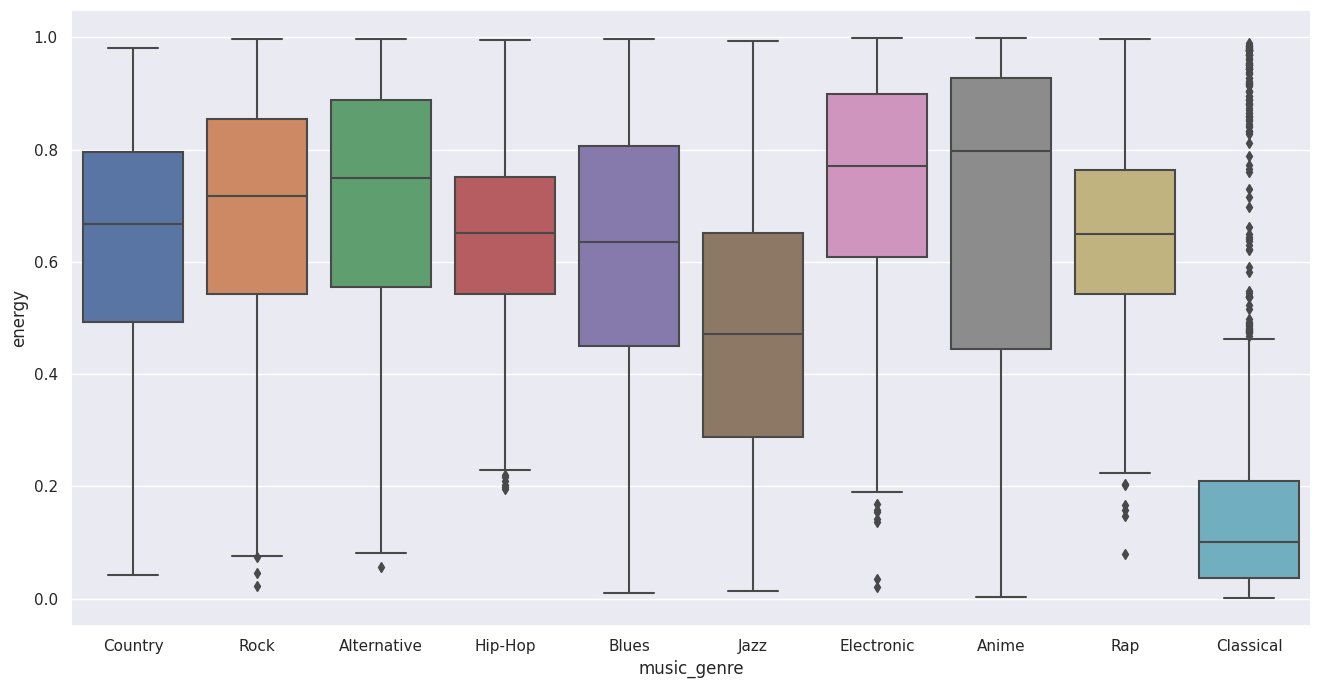

In [38]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='energy')
plt.show()

#### liveness

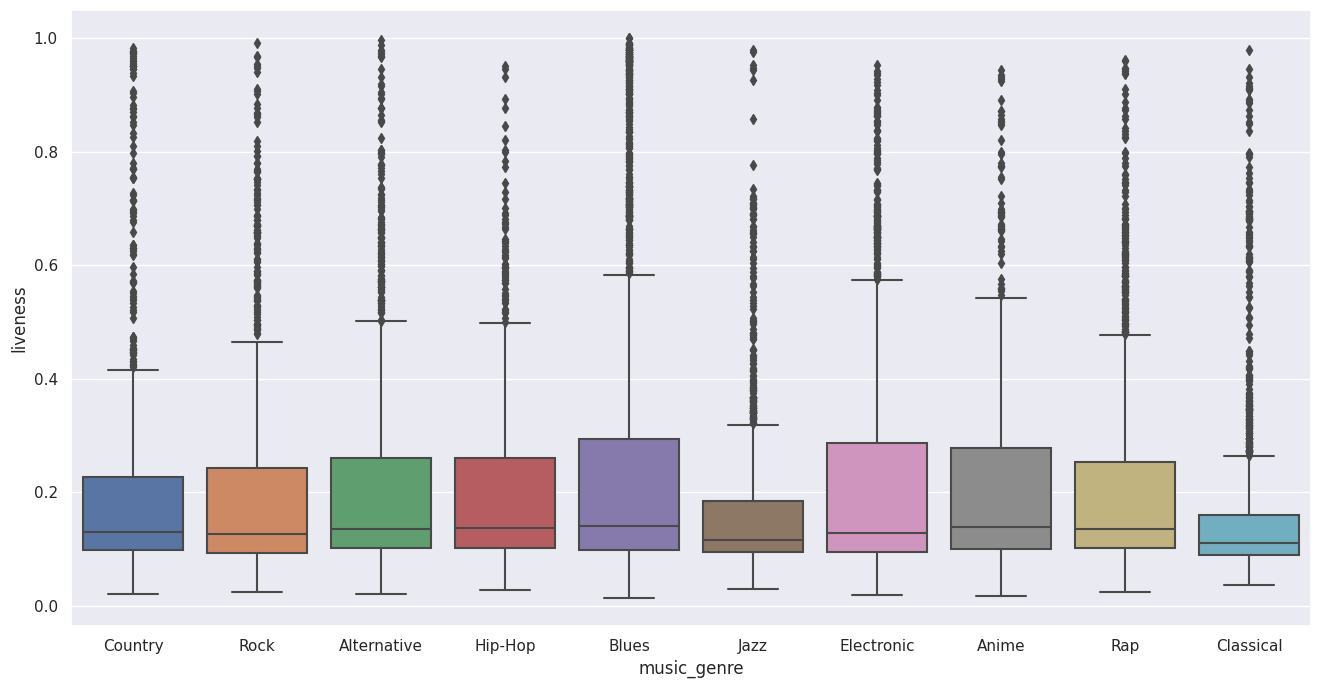

In [39]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='liveness')
plt.show()

#### loudness

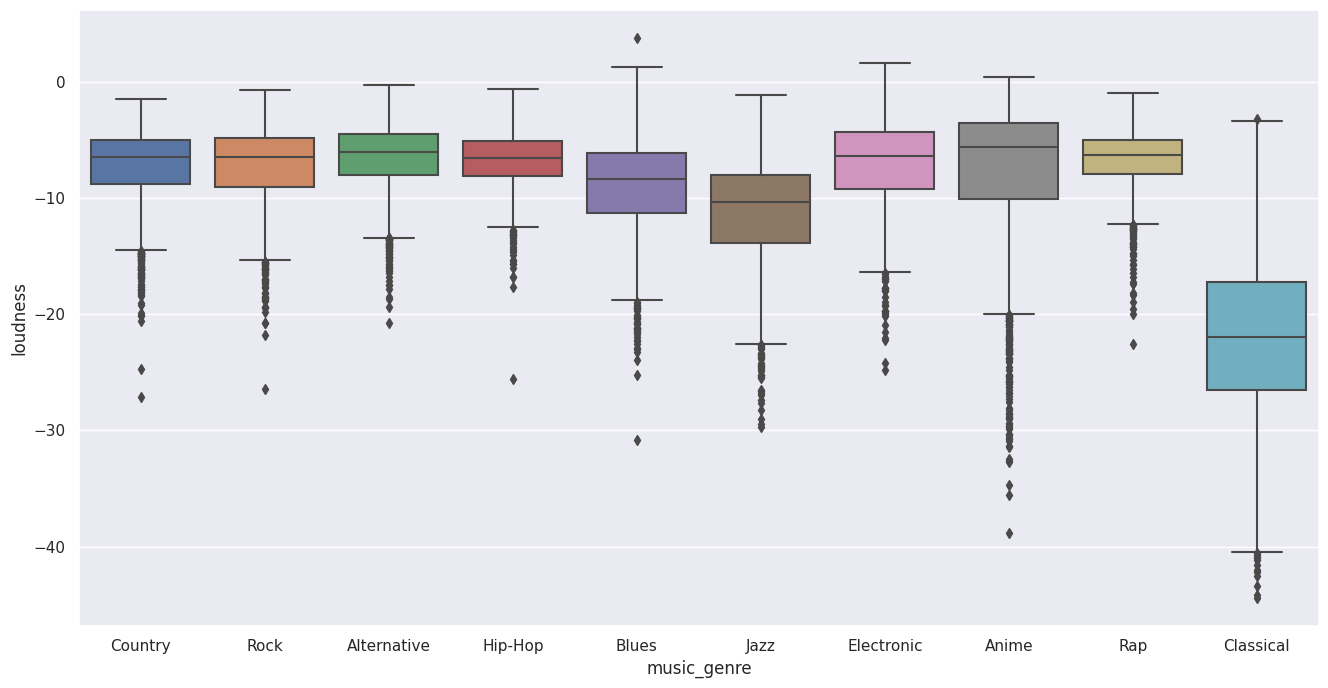

In [40]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='loudness')
plt.show()

#### valence 

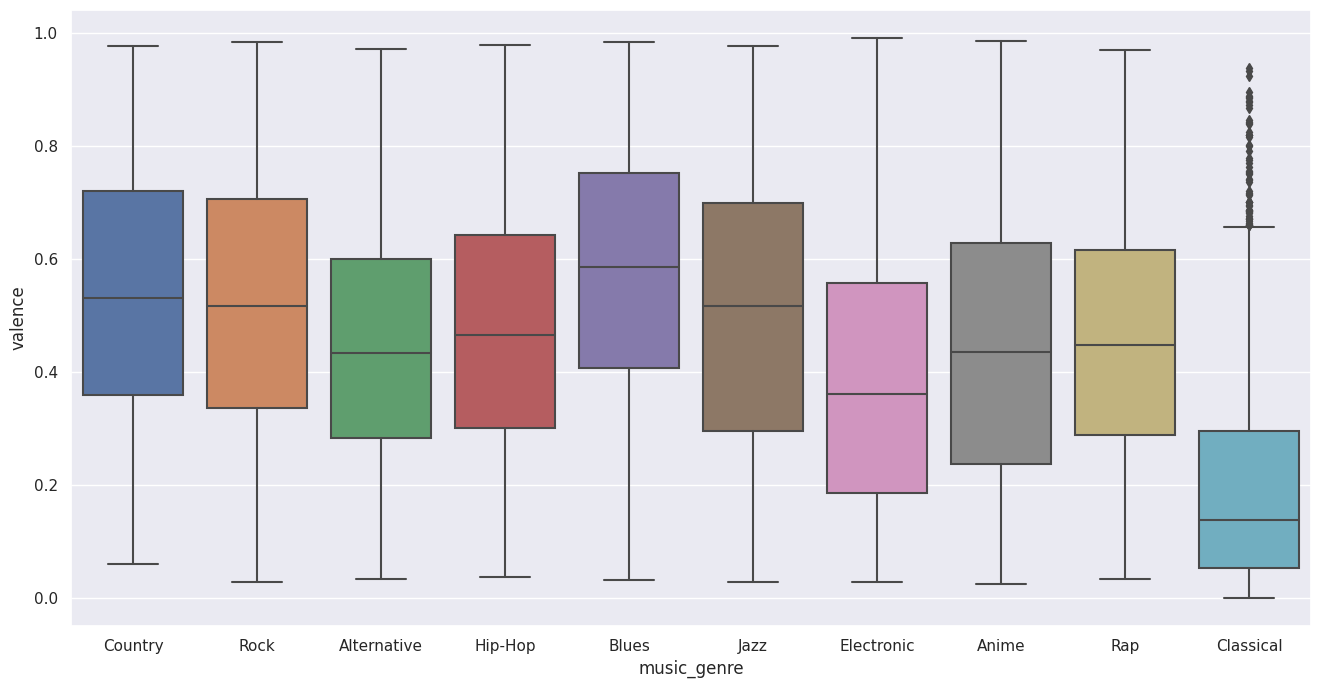

In [41]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_train, x='music_genre', y='valence')
plt.show()

Легитимные фичи. Оставлены как есть. Самый выбивающийся жанр по распределениям - классика. 

## Итоги EDA

### Фичи

* Большинство численных признаков оставлены как есть
* `duration_ms`, `tempo` - пропуски обрабоны, заполнены медианой
* `key`, `mode` - применен OHE
* `instance_id`, `obtained_date`, `instrumentalness`, `track_name` - неинформативные фичи, были убраны. На основе последнего было создано 2 новых признака - `lenth_track_name` и `cjk`.

### Общие наблюдения 

Большинство жанров, как правило, имеют очень похожее распределение большинства фичей, что затрудняет различие между ними с помощью какой-либо модели. Очевидным исключением является классическая музыка, которая имеет очень разные распределения. Жанр аниме также демонстрирует некоторые отличительные черты, как и джаз, в меньшей степени. Хип-хоп и рэп чрезвычайно похожи друг на друга во всех чертах, но в некоторых чертах отличаются от остальных жанров. В целом, текущие фичи вряд ли дадут хорошие прогнозы для всех жанров, кроме классики и аниме.

## Препроцессинг

### Кодировка таргета

In [42]:
df_train['music_genre'] = df_train['music_genre'].astype('category')
y_train = df_train['music_genre'].cat.codes
y_train_names = list(df_train['music_genre'].cat.categories)
X_train = df_train.drop(columns=['music_genre'])
X_test = df_test

### Стандартизация

Будем применять RobustScaler для уменьшения чувствительности к выбросам.

In [43]:
scaler = RobustScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Выбросы 

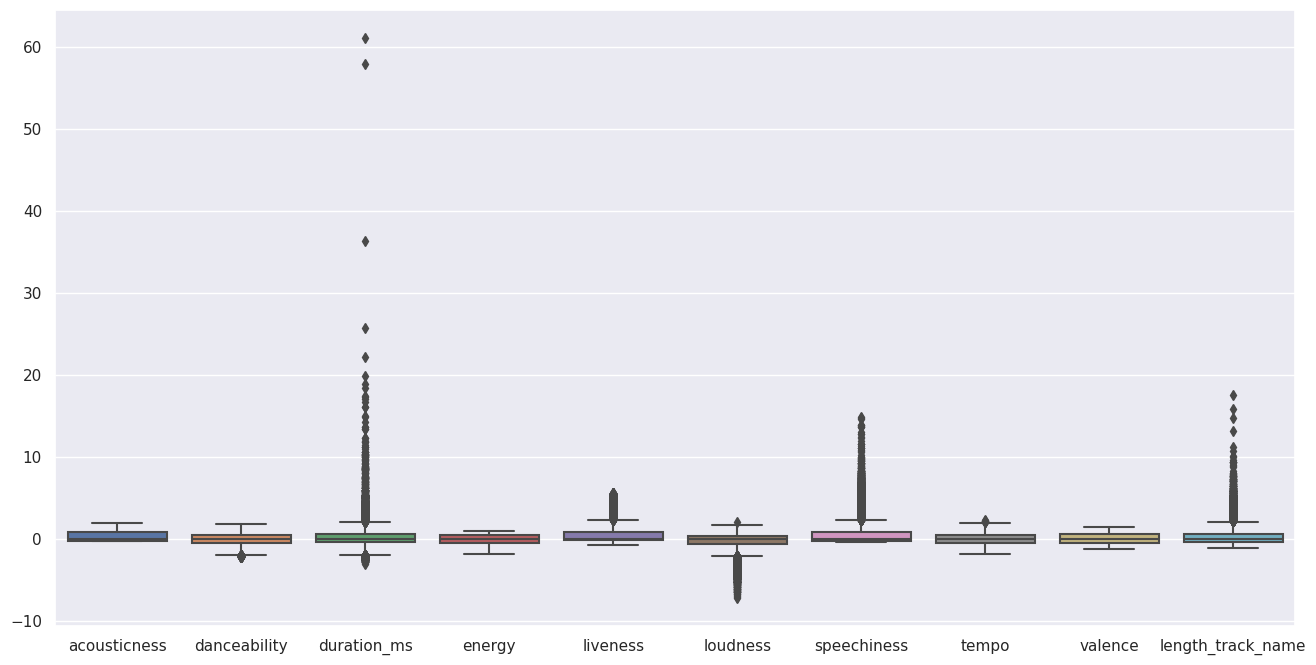

In [44]:
numerical_feats = ['acousticness', 'danceability', 'duration_ms', 'energy',
                   'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'length_track_name']

plt.figure(figsize=(16,8))
sns.boxplot(data=X_train[numerical_feats])
plt.show()

Как видим, серьезные выбросы наблюдаем только в фиче `duration_ms` и в меньшей степени в `length_track_name`. Как мне кажется, такие выбросы даже *помогут* моделям определять жанр - оба признака большие индикаторы классических треков. Оставим как есть.

### Корреляционная матрица

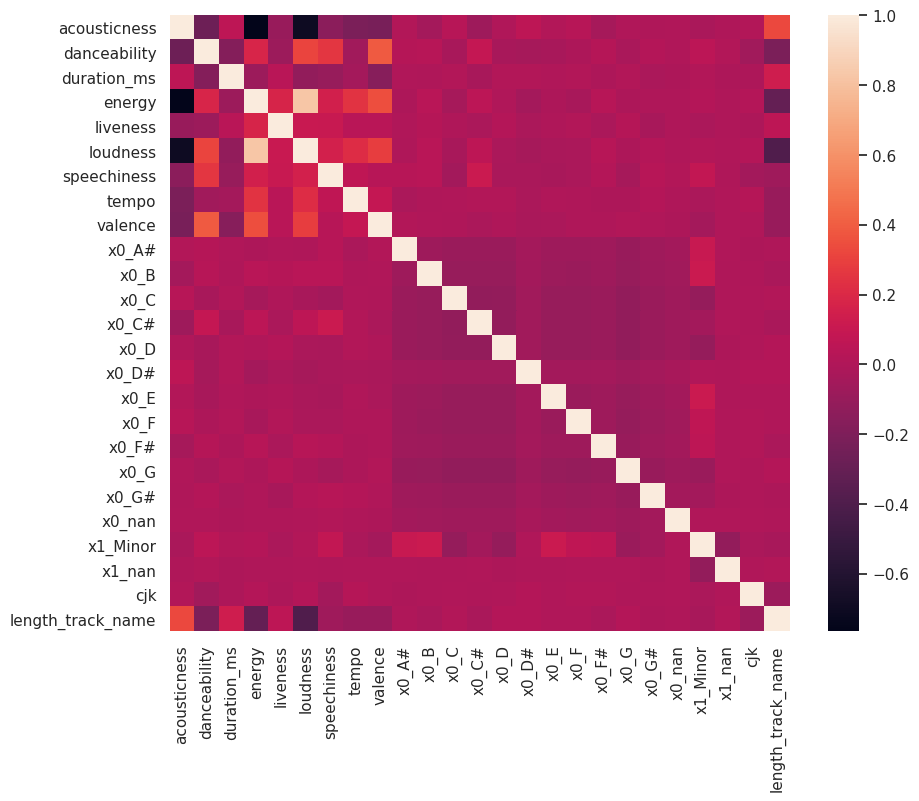

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), annot=False)
plt.show()

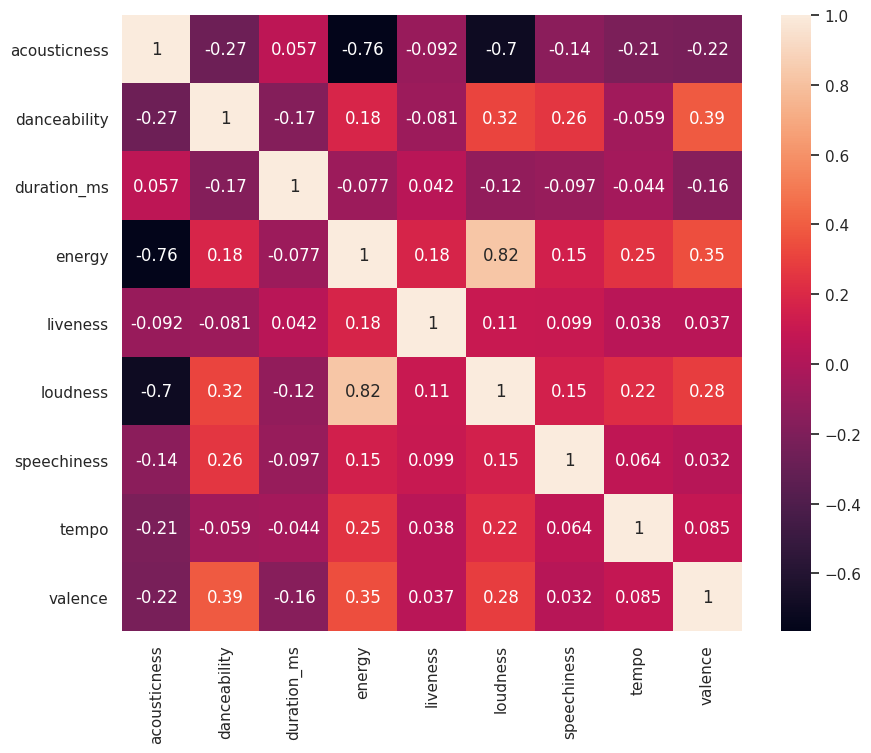

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.iloc[:,:9].corr(), annot=True)
plt.show()

Наблюдаем высокие корреляции `loudness`, `energy` и `acousticness`. 

In [47]:
X_vif = X_train[['loudness','energy','acousticness']]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
print(vif_data)

        Feature       VIF
0      loudness  3.388643
1        energy  3.700395
2  acousticness  2.475520


Тем не менее их variance inflation мал, оставим как есть.

## Модели

Я выбрал 3 модели для этой классификации. Целевая метрика задания - F1.

In [48]:
metrics = pd.DataFrame(
    index=['LogReg', 'RanForest', 'CatBoost'],
    columns=['F1-score'])

kf = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

### Logistic Regression

In [49]:
%%time
# подбор гиперпараметров и оценка
# логистической регресии 
lr_grid = {'C': [0.01,0.1,1],
    'solver': ['newton-cg', 'liblinear']}

lr_model = LogisticRegression(
    class_weight=None,
    random_state=RANDOM_STATE,
    n_jobs=1)

best_lr_model = GridSearchCV(
    lr_model,
    lr_grid,
    scoring='f1_micro',
    n_jobs=-1,
    cv=kf)

best_lr_model.fit(X_train, y_train)

CPU times: user 7.52 s, sys: 14.9 s, total: 22.4 s
Wall time: 15.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(n_jobs=1, random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'solver': ['newton-cg', 'liblinear']},
             scoring='f1_micro')

In [50]:
metrics.loc['LogReg', 'F1-score'] = best_lr_model.best_score_
print(
    'Лучшие параметры для логистической регрессии:',
    best_lr_model.best_params_
    )

Лучшие параметры для логистической регрессии: {'C': 0.1, 'solver': 'newton-cg'}


### Random Forest

In [51]:
%%time
# подбор гиперпараметров и оценка
# случайного леса
rf_grid = {'n_estimators': range(100, 300, 50),
    'criterion': ['gini','entropy'],
    'max_depth': range(10, 21, 5),
    'min_samples_split': range(2, 3),
    'min_samples_leaf': range(1, 2)}

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight=None)

best_rf_model = GridSearchCV(
    rf_model,
    rf_grid,
    scoring='f1_micro',
    n_jobs=-1,
    cv=kf)

best_rf_model.fit(X_train, y_train)

CPU times: user 25.5 s, sys: 769 ms, total: 26.3 s
Wall time: 5min 44s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 21, 5),
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(2, 3),
                         'n_estimators': range(100, 300, 50)},
             scoring='f1_micro')

In [52]:
metrics.loc['RanForest', 'F1-score'] = best_rf_model.best_score_
print(
    'Лучшие параметры для  рандомного леса:',
    best_rf_model.best_params_
    )

Лучшие параметры для  рандомного леса: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


### CatBoost

In [53]:
%%time
# подбор гиперпараметров и оценка
# градиентного бустинга
cat_grid = {
    'depth': [6],
    'iterations': [1000],
    'learning_rate': [.03],
    'l2_leaf_reg': [3]}

cat_model = CatBoostClassifier(
    od_pval=.01,
    random_state=RANDOM_STATE,
    logging_level='Silent',
    #eval_metric='F1',
    loss_function='MultiClass',
    auto_class_weights='Balanced')

best_cat_model = GridSearchCV(
    cat_model,
    cat_grid,
    scoring='f1_micro',
    n_jobs=-1,
    cv=kf)

best_cat_model.fit(X_train, y_train)

CPU times: user 2min 47s, sys: 6.09 s, total: 2min 53s
Wall time: 3min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f94fab72f40>,
             n_jobs=-1,
             param_grid={'depth': [6], 'iterations': [1000], 'l2_leaf_reg': [3],
                         'learning_rate': [0.03]},
             scoring='f1_micro')

In [54]:
#submit.to_csv('oogabooga.csv', index=False)

In [55]:
metrics.loc['CatBoost', 'F1-score'] = best_cat_model.best_score_
print(
    'Лучшие параметры для catboost',
    best_cat_model.best_params_
    )

Лучшие параметры для catboost {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


In [56]:
metrics

,F1-score
LogReg,0.396391
RanForest,0.446994
CatBoost,0.436697


Лучшие результаты показывает случайный лес.

# Вывод 

Результаты довольно плохие. Распределения признаков для классов слишком похожи, чтобы модели справлялись с ними хорошо.